
AI-POWERED CPU SCHEDULER TRAINING
Objectives: High Utilization + Low Latency
LOADING AND PREPROCESSING DATA

Dataset shape: (1007, 22)
Number of processes: 336

Missing values before cleaning:
cpu_percent              0
memory_percent           0
memory_mb                0
num_threads              0
nice                     0
process_age              0
io_intensity             0
user_time                0
system_time              0
system_cpu_percent       0
system_memory_percent    0
system_load_1min         0
dtype: int64

Dataset shape after outlier removal: (527, 22)

CREATING TARGET LABELS

Priority Score Statistics:
count    527.000000
mean      42.340152
std        7.640268
min        6.420000
25%       37.005000
50%       42.590000
75%       47.175000
max       55.980000
dtype: float64

Priority Class Distribution:
Low          14
Medium      443
High         70
Critical      0
Name: count, dtype: int64

✓ Labeled dataset saved: labeled_dataset.csv

Training set size: (421, 12

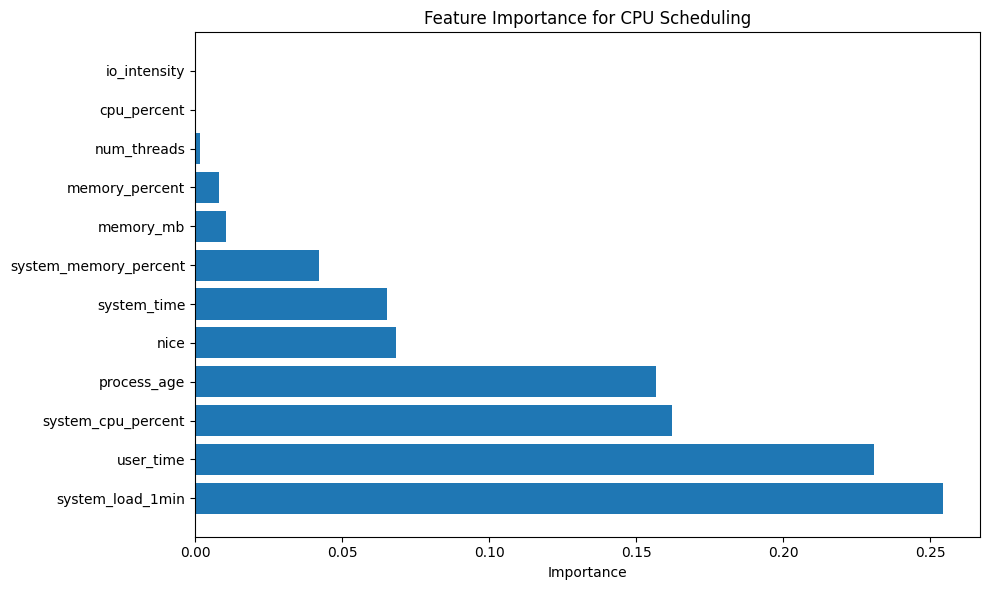

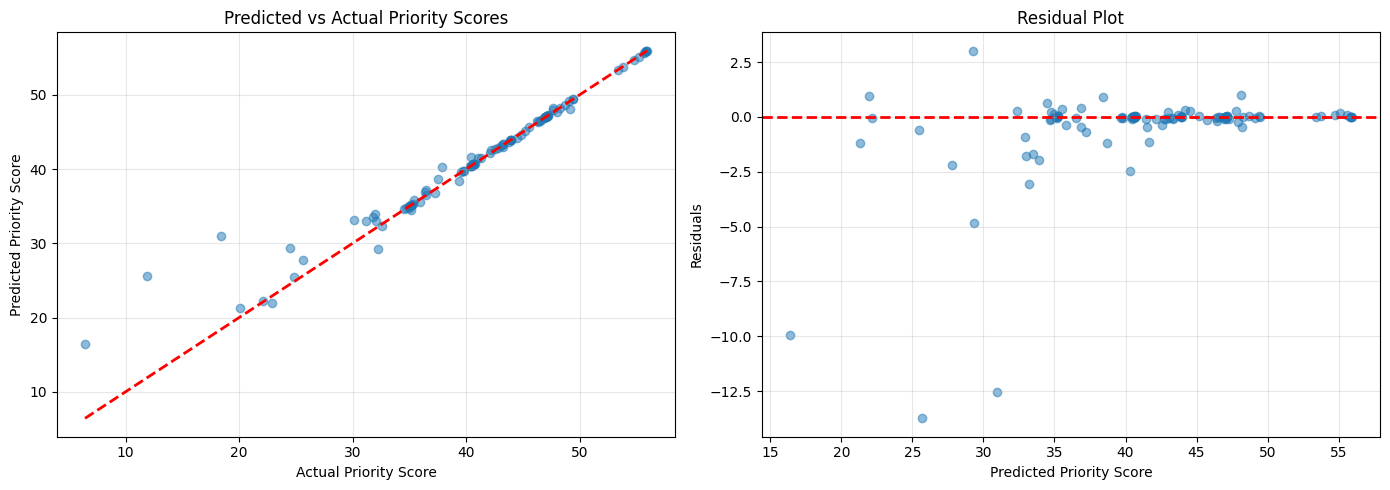

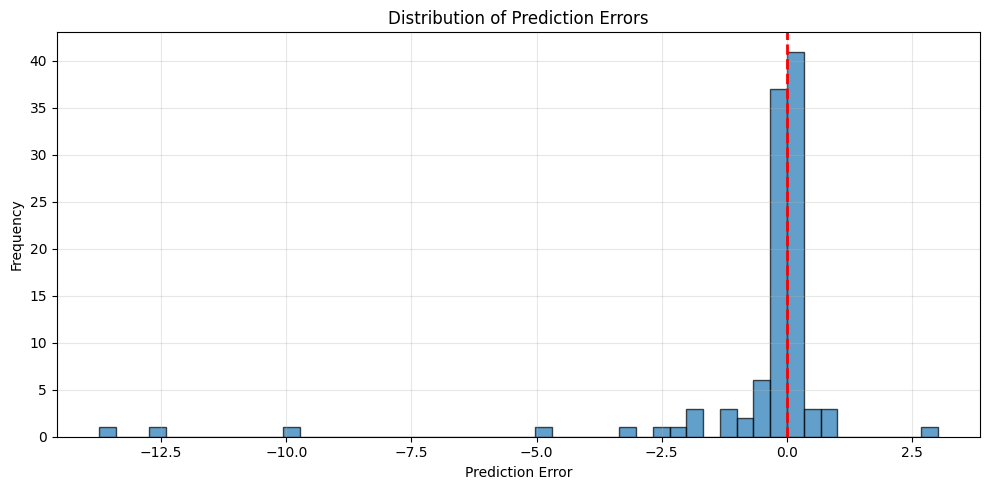

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

class CPUSchedulerTrainer:
    """
    Train AI models for CPU scheduling optimization
    Objectives:
    1. Maximize CPU utilization
    2. Minimize latency (response time)
    3. Maintain system balance
    """
    
    def __init__(self, features):
        self.features = features
        self.scaler = StandardScaler()
        self.models = {}
        self.best_model = None
        self.feature_importance = None
        
    def load_and_preprocess(self, filepath):
        """Load and preprocess the dataset"""
        print("=" * 60)
        print("LOADING AND PREPROCESSING DATA")
        print("=" * 60)
        
        df = pd.read_csv(filepath)
        print(f"\nDataset shape: {df.shape}")
        print(f"Number of processes: {df['pid'].nunique() if 'pid' in df.columns else 'N/A'}")
        
        # Check for missing features
        missing_features = [f for f in self.features if f not in df.columns]
        if missing_features:
            print(f"\nWarning: Missing features: {missing_features}")
            self.features = [f for f in self.features if f in df.columns]
            print(f"Using available features: {self.features}")
        
        # Handle missing values
        print(f"\nMissing values before cleaning:\n{df[self.features].isnull().sum()}")
        df[self.features] = df[self.features].fillna(df[self.features].median())
        
        # Remove outliers using IQR method
        df_clean = self.remove_outliers(df, self.features)
        print(f"\nDataset shape after outlier removal: {df_clean.shape}")
        
        return df_clean
    
    def remove_outliers(self, df, features, threshold=3):
        """Remove outliers using IQR method"""
        df_clean = df.copy()
        for feature in features:
            Q1 = df_clean[feature].quantile(0.25)
            Q3 = df_clean[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            df_clean = df_clean[(df_clean[feature] >= lower_bound) & 
                               (df_clean[feature] <= upper_bound)]
        return df_clean
    
    def create_target_labels(self, df):
        """
        Create target labels for scheduling priority
        
        Priority Score Formula:
        - High CPU utilization contribution (process should run if it uses CPU well)
        - Low latency (prioritize processes with short bursts and high wait times)
        - Balance fairness (consider process age and nice value)
        """
        print("\n" + "=" * 60)
        print("CREATING TARGET LABELS")
        print("=" * 60)
        
        # Normalize features to 0-1 scale for scoring
        def normalize(series):
            min_val, max_val = series.min(), series.max()
            if max_val - min_val == 0:
                return pd.Series(0, index=series.index)
            return (series - min_val) / (max_val - min_val)
        
        # Component 1: CPU Efficiency Score (want processes that use CPU effectively)
        # Higher CPU% = better utilization
        cpu_efficiency = normalize(df['cpu_percent'])
        
        # Component 2: Latency Score (prioritize short-burst, waiting processes)
        # Use estimated burst time if available, otherwise use recent CPU time
        if 'burst_time_estimate' in df.columns:
            burst_score = 1 - normalize(df['burst_time_estimate'])  # Shorter burst = higher priority
        else:
            # Approximate: processes with lower total CPU time might have shorter bursts
            burst_score = 1 - normalize(df['user_time'] + df['system_time'])
        
        # Waiting time score (if available)
        if 'current_wait_time' in df.columns:
            wait_score = normalize(df['current_wait_time'])  # Longer wait = higher priority
        else:
            wait_score = 0.3  # Default moderate score
        
        # Component 3: System Balance Score
        # Consider system load - prioritize when system is underutilized
        system_util = normalize(df['system_cpu_percent'])
        balance_score = 1 - system_util  # Lower system CPU = more room for scheduling
        
        # Component 4: Fairness Score
        # Consider nice value (lower nice = higher priority)
        if 'nice' in df.columns:
            nice_score = 1 - normalize(df['nice'] + 20)  # Shift nice range to positive
        else:
            nice_score = 0.5
        
        # Process age (older processes should get priority to avoid starvation)
        age_score = normalize(df['process_age'])
        
        # Component 5: Resource Availability Score
        # Check if system has resources available
        memory_available = 1 - normalize(df['system_memory_percent'])
        
        # Weighted Priority Score
        # Weights tuned for: high utilization + low latency
        priority_score = (
            0.30 * cpu_efficiency +      # CPU utilization contribution
            0.25 * burst_score +          # Short burst preference
            0.20 * wait_score +           # Waiting time consideration
            0.10 * balance_score +        # System balance
            0.08 * nice_score +           # Priority value
            0.05 * age_score +            # Fairness/starvation prevention
            0.02 * memory_available       # Resource availability
        )
        
        # Normalize final score to 0-100 range
        priority_score = (priority_score * 100).round(2)
        
        print(f"\nPriority Score Statistics:")
        print(priority_score.describe())
        
        # Create priority classes for classification (optional)
        priority_class = pd.cut(priority_score, 
                               bins=[0, 25, 50, 75, 100],
                               labels=['Low', 'Medium', 'High', 'Critical'],
                               include_lowest=True)
        
        print(f"\nPriority Class Distribution:")
        print(priority_class.value_counts().sort_index())
        
        return priority_score, priority_class
    
    def prepare_training_data(self, df, priority_score):
        """Prepare features and target for training"""
        X = df[self.features].copy()
        y = priority_score
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, shuffle=True
        )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        print(f"\nTraining set size: {X_train_scaled.shape}")
        print(f"Test set size: {X_test_scaled.shape}")
        
        return X_train_scaled, X_test_scaled, y_train, y_test
    
    def train_models(self, X_train, X_test, y_train, y_test):
        """Train multiple models and compare performance"""
        print("\n" + "=" * 60)
        print("TRAINING MODELS")
        print("=" * 60)
        
        # Define models
        models_config = {
            'Random Forest': RandomForestRegressor(
                n_estimators=100,
                max_depth=15,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=42,
                n_jobs=-1
            ),
            'Gradient Boosting': GradientBoostingRegressor(
                n_estimators=100,
                max_depth=7,
                learning_rate=0.1,
                min_samples_split=10,
                random_state=42
            ),
            'Neural Network': MLPRegressor(
                hidden_layer_sizes=(64, 32, 16),
                activation='relu',
                solver='adam',
                learning_rate='adaptive',
                max_iter=500,
                random_state=42,
                early_stopping=True
            )
        }
        
        results = []
        
        for name, model in models_config.items():
            print(f"\nTraining {name}...")
            
            # Train model
            model.fit(X_train, y_train)
            
            # Predictions
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Metrics
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            train_mae = mean_absolute_error(y_train, y_train_pred)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)
            
            # Cross-validation score
            cv_scores = cross_val_score(model, X_train, y_train, 
                                       cv=5, scoring='neg_mean_squared_error')
            cv_rmse = np.sqrt(-cv_scores.mean())
            
            results.append({
                'Model': name,
                'Train RMSE': train_rmse,
                'Test RMSE': test_rmse,
                'Train MAE': train_mae,
                'Test MAE': test_mae,
                'Train R²': train_r2,
                'Test R²': test_r2,
                'CV RMSE': cv_rmse
            })
            
            # Store model
            self.models[name] = {
                'model': model,
                'test_rmse': test_rmse,
                'test_r2': test_r2
            }
            
            print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
            print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
            print(f"  CV RMSE: {cv_rmse:.4f}")
        
        # Results comparison
        results_df = pd.DataFrame(results)
        print("\n" + "=" * 60)
        print("MODEL COMPARISON")
        print("=" * 60)
        print(results_df.to_string(index=False))
        
        # Select best model (lowest test RMSE)
        best_model_name = results_df.loc[results_df['Test RMSE'].idxmin(), 'Model']
        self.best_model = self.models[best_model_name]['model']
        print(f"\n🏆 Best Model: {best_model_name}")
        
        return results_df
    
    def analyze_feature_importance(self, X_train):
        """Analyze feature importance from best model"""
        print("\n" + "=" * 60)
        print("FEATURE IMPORTANCE ANALYSIS")
        print("=" * 60)
        
        if hasattr(self.best_model, 'feature_importances_'):
            importance = self.best_model.feature_importances_
            feature_importance_df = pd.DataFrame({
                'Feature': self.features,
                'Importance': importance
            }).sort_values('Importance', ascending=False)
            
            print("\n", feature_importance_df.to_string(index=False))
            self.feature_importance = feature_importance_df
            
            # Plot
            plt.figure(figsize=(10, 6))
            plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
            plt.xlabel('Importance')
            plt.title('Feature Importance for CPU Scheduling')
            plt.tight_layout()
            plt.savefig('feature_importance.png', dpi=300)
            print("\n✓ Feature importance plot saved: feature_importance.png")
        else:
            print("Feature importance not available for this model type")
    
    def visualize_predictions(self, X_test, y_test):
        """Visualize model predictions vs actual values"""
        print("\n" + "=" * 60)
        print("GENERATING VISUALIZATIONS")
        print("=" * 60)
        
        y_pred = self.best_model.predict(X_test)
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Scatter plot
        axes[0].scatter(y_test, y_pred, alpha=0.5)
        axes[0].plot([y_test.min(), y_test.max()], 
                     [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0].set_xlabel('Actual Priority Score')
        axes[0].set_ylabel('Predicted Priority Score')
        axes[0].set_title('Predicted vs Actual Priority Scores')
        axes[0].grid(True, alpha=0.3)
        
        # Residual plot
        residuals = y_test - y_pred
        axes[1].scatter(y_pred, residuals, alpha=0.5)
        axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
        axes[1].set_xlabel('Predicted Priority Score')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residual Plot')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('model_predictions.png', dpi=300)
        print("✓ Prediction plots saved: model_predictions.png")
        
        # Error distribution
        plt.figure(figsize=(10, 5))
        plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
        plt.title('Distribution of Prediction Errors')
        plt.axvline(x=0, color='r', linestyle='--', lw=2)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('error_distribution.png', dpi=300)
        print("✓ Error distribution saved: error_distribution.png")
    
    def save_model(self, filepath='scheduler_model.pkl'):
        """Save the trained model and scaler"""
        model_package = {
            'model': self.best_model,
            'scaler': self.scaler,
            'features': self.features,
            'feature_importance': self.feature_importance
        }
        joblib.dump(model_package, filepath)
        print(f"\n✓ Model saved to: {filepath}")
    
    def predict_priority(self, process_features):
        """Predict priority score for new process(es)"""
        # Ensure features are in correct order
        X = process_features[self.features]
        X_scaled = self.scaler.transform(X)
        priority = self.best_model.predict(X_scaled)
        return priority


def main():
    """Main training pipeline"""
    print("\n" + "=" * 60)
    print("AI-POWERED CPU SCHEDULER TRAINING")
    print("Objectives: High Utilization + Low Latency")
    print("=" * 60)
    
    # Feature set
    features = [
        "cpu_percent", "memory_percent", "memory_mb", "num_threads",
        "nice", "process_age", "io_intensity", "user_time", "system_time",
        "system_cpu_percent", "system_memory_percent", "system_load_1min"
    ]
    
    # Initialize trainer
    trainer = CPUSchedulerTrainer(features)
    
    # Load and preprocess data
    dataset_path = input("\nEnter dataset path (default: dataset_a.csv): ").strip()
    if not dataset_path:
        dataset_path = "dataset_a.csv"
    
    df = trainer.load_and_preprocess(dataset_path)
    
    # Create target labels
    priority_score, priority_class = trainer.create_target_labels(df)
    
    # Add to dataframe for reference
    df['priority_score'] = priority_score
    df['priority_class'] = priority_class
    
    # Save labeled dataset
    df.to_csv('labeled_dataset.csv', index=False)
    print("\n✓ Labeled dataset saved: labeled_dataset.csv")
    
    # Prepare training data
    X_train, X_test, y_train, y_test = trainer.prepare_training_data(df, priority_score)
    
    # Train models
    results = trainer.train_models(X_train, X_test, y_train, y_test)
    
    # Analyze feature importance
    trainer.analyze_feature_importance(X_train)
    
    # Visualize results
    trainer.visualize_predictions(X_test, y_test)
    
    # Save model
    trainer.save_model('scheduler_model.pkl')
    
    print("\n" + "=" * 60)
    print("TRAINING COMPLETE!")
    print("=" * 60)
    print("\nGenerated files:")
    print("  1. labeled_dataset.csv - Dataset with priority scores")
    print("  2. scheduler_model.pkl - Trained model")
    print("  3. feature_importance.png - Feature importance visualization")
    print("  4. model_predictions.png - Prediction quality plots")
    print("  5. error_distribution.png - Error analysis")
    
    # Demo prediction
    print("\n" + "=" * 60)
    print("DEMO: Testing Model Prediction")
    print("=" * 60)
    
    # Take a sample from test set
    sample_idx = np.random.randint(0, len(X_test))
    sample = pd.DataFrame([X_test[sample_idx]], columns=features)
    
    predicted_priority = trainer.predict_priority(sample)
    actual_priority = y_test.iloc[sample_idx]
    
    print(f"\nSample Process Features:")
    for feat, val in zip(features, X_test[sample_idx]):
        print(f"  {feat}: {val:.4f}")
    
    print(f"\nPredicted Priority: {predicted_priority[0]:.2f}")
    print(f"Actual Priority: {actual_priority:.2f}")
    print(f"Error: {abs(predicted_priority[0] - actual_priority):.2f}")


if __name__ == "__main__":
    main()

In [1]:
import pandas as pd

# Load your CSV
data = pd.read_csv("dataset_a.csv")

# Select features for ML
features = [
    'cpu_percent', 'memory_percent', 'memory_mb', 'num_threads',
    'nice', 'process_age', 'io_intensity', 'user_time', 'system_time'
]

# Some columns may be categorical
if 'process_type' in data.columns:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    data['process_type'] = le.fit_transform(data['process_type'])
    features.append('process_type')

# Target: CPU burst
# If you don't have 'estimated_remaining_cpu_burst', you can calculate burst like this:
# burst_time = (next_snapshot_cpu_time - current_snapshot_cpu_time) OR sum of user+system time in burst
# For simplicity, we use user_time + system_time as approximate burst
data['burst_time'] = data['user_time'] + data['system_time']

# Drop rows with missing values
data = data.dropna(subset=features + ['burst_time'])

X = data[features]
y = data['burst_time']


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Train XGBoost regressor
model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1)
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_test_scaled)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


MAE: 9.051896102947763
RMSE: 37.999080884648585


c:\Users\Apurav\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [7]:
import pandas as pd

# Sample process data
sample_data = pd.DataFrame([
    {'cpu_percent': 5.0, 'memory_percent': 10.0, 'memory_mb': 100, 'num_threads': 4,
     'nice': 0, 'process_age': 0.0, 'io_intensity': 0, 'user_time': 0.0, 'system_time': 0.0,
     'process_type': 'system'},
    {'cpu_percent': 15.0, 'memory_percent': 30.0, 'memory_mb': 500, 'num_threads': 8,
     'nice': 0, 'process_age': 0.0, 'io_intensity': 1, 'user_time': 100.0, 'system_time': 5.0,
     'process_type': 'interactive'},
    {'cpu_percent': 8.0, 'memory_percent': 20.0, 'memory_mb': 200, 'num_threads': 2,
     'nice': 0, 'process_age': 0.0, 'io_intensity': 0, 'user_time': 50.0, 'system_time': 2.0,
     'process_type': 'other'},
])

features = ['cpu_percent', 'memory_percent', 'memory_mb', 'num_threads', 
            'nice', 'process_age', 'io_intensity', 'user_time', 'system_time', 'process_type']


In [8]:
from sklearn.preprocessing import LabelEncoder

# Use same label encoder used during training
# For example, if you did: le = LabelEncoder(); le.fit(training_data['process_type'])
sample_data['process_type'] = le.transform(sample_data['process_type'])


In [9]:
# Scale features
X_sample_scaled = scaler.transform(sample_data[features])

# Predict burst
y_sample_pred = model.predict(X_sample_scaled)
sample_data['predicted_burst'] = y_sample_pred

print(sample_data)


   cpu_percent  memory_percent  memory_mb  num_threads  nice  process_age  \
0          5.0            10.0        100            4     0          0.0   
1         15.0            30.0        500            8     0          0.0   
2          8.0            20.0        200            2     0          0.0   

   io_intensity  user_time  system_time  process_type  predicted_burst  
0             0        0.0          0.0             3        27.935862  
1             1      100.0          5.0             1        98.232353  
2             0       50.0          2.0             2        64.861275  
